# Imports e  Constantes



In [1]:
import pygame
import random
import requests
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import pickle
import os, sys
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
# Constants for the game grid
GRID_SIZE = 40
GRID_WIDTH = 10
GRID_HEIGHT = 10

# Define actions
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Up, Down, Left, Right

# Colors
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)  # Color for the snake's head


#Ambiente e Agente

In [67]:
class SnakeGame():
    def __init__(self, delay_time = 0.000005):
        pygame.init()
        self.screen = pygame.display.set_mode((GRID_WIDTH * GRID_SIZE, GRID_HEIGHT * GRID_SIZE))
        pygame.display.set_caption("Snake Game - RL")
        self.delay_time = delay_time
        self.reset()

    def get_state(self):
      s = self.snake[0]
      f = self.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)

    def reset(self):
        self.food = self.initialize_food()
        self.snake = self.initialize_snake(food = self.food)

    def initialize_food(self):
        empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
        return random.choice(empty_cells)

    def initialize_snake(self, food):
        empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
        empty_cells.remove(food)
        return [random.choice(empty_cells)]

    def is_valid_move(self, action):
        new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])
        #print("new_head[0]", new_head[0] < 0)
        #print("new_head[0]", new_head[0] >= GRID_WIDTH)
        #print("new_head[1]", new_head[1] < 0)
        #print("new_head[1]", new_head[1] >= GRID_HEIGHT)
        #print("new_head in ", new_head in self.snake) # erro esta aqui
        if (
            new_head[0] < 0
            or new_head[0] >= GRID_WIDTH
            or new_head[1] < 0
            or new_head[1] >= GRID_HEIGHT
            or new_head in self.snake
        ):
            return False

        return True

    def step(self, reward_shape, method = 'random', value_function = None, N0 = 1, N = 1,
             test_only = False, stochastic = False, stochastic_level = 0.9):

      reward = 0
      get = False
      # valid_actions = [action for action in ACTIONS if self.is_valid_move(action)]
      # action = random.choice(ACTIONS)
      action = self.get_desired_action(method = method, value_function = value_function, N0 = N0, N = N, test_only = test_only)
      is_valid = self.is_valid_move(action)
      while not is_valid:
          #print("Nao e valido")
          action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
          reward = -1
          is_valid = self.is_valid_move(action)
          #return reward, True  # No reward and episode ends
      #print("Action Selected", action)
      if self.snake[0] == self.food:
          self.food = self.initialize_food()
          self.snake.append((0, 0))
          reward = reward_shape[1]
          get = True
      else:
          reward = -1
      #elif action != self.get_desired_action():
      #    reward = reward_shape[0]

      if stochastic == 'all': #se todo tabuleiro é estocastico
        if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

          action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
          is_valid = self.is_valid_move(action)
          while not is_valid:
              #print("Nao e valido")
              action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
              reward = -1
              is_valid = self.is_valid_move(action)


      if stochastic == 'up': #se a parte de cima do tabuleiro é estocastico

        if self.snake[0][0] <=4:
          if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

            action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
            is_valid = self.is_valid_move(action)
            while not is_valid:
                #print("Nao e valido")
                action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
                reward = -1
                is_valid = self.is_valid_move(action)


      if stochastic == 'type2': #se a parte de cima do tabuleiro é estocastico

        state = self.get_state()

        if state[0] == 0 or state[1] == 0: #se estiver na mesma "reta" que a fruta
          if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

            action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
            is_valid = self.is_valid_move(action)
            while not is_valid:
                #print("Nao e valido")
                action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
                reward = -1
                is_valid = self.is_valid_move(action)

      new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])

      self.snake.insert(0, new_head)
      self.snake.pop()

      return reward, True, get, action


    def render(self, render = True):

        if not render:
          return None

        self.screen.fill(WHITE)
        for i, segment in enumerate(self.snake):
            if i == 0:
                pygame.draw.rect(self.screen, BLUE, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
            else:
                pygame.draw.rect(self.screen, GREEN, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
        pygame.draw.rect(self.screen, RED, (self.food[0] * GRID_SIZE, self.food[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
        pygame.display.update()

        #to run in Colab:
        #convert image so it can be displayed in OpenCV
        view = pygame.surfarray.array3d(self.screen)
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_bgr)
        time.sleep(self.delay_time)
        output.clear()

    # Optmization that make snake go only to the direction of the food, instead of choosing a random direction
    def get_desired_action(self, method = 'random', value_function = None, N0 = 1, N = 1, test_only = False):
        head = self.snake[0]
        food = self.food
        delta_x = food[0] - head[0]
        delta_y = food[1] - head[1]


        if method == 'best':
          if delta_x > 0:
              return (1, 0)  # Right
          elif delta_x < 0:
              return (-1, 0)  # Left
          elif delta_y > 0:
              return (0, 1)  # Down
          elif delta_y < 0:
              return (0, -1)  # Up
          else:
              return (0, 0)  # No movement


        #choose a random action
        if method  == 'random':
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          idx = np.random.choice([0,1,2,3])
          return possible_actions[idx]

        if method == 'value':
          #print(N0)
          epsilon = N0/(N0+N)

          if test_only:
            epsilon = 0.01

          if np.random.uniform(0,1,1)[0] < epsilon:
            possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
            idx = np.random.choice([0,1,2,3])
            return possible_actions[idx]

          state = self.get_state()
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          max_value = -np.inf
          for a in possible_actions:

            future_state = (state[0] + a[0], state[1] +a[1])
            if self.is_valid_move(a):
              #print(future_state,state,  self.snake, self.food, value_function[str(future_state)])
              if value_function[str(future_state)] >= max_value:
                f = future_state
                v = value_function[str(future_state)]
                max_value = value_function[str(future_state)]
                action = a

          #print('--', v, f, action)
          return action



In [68]:
class MonteCarloAgent():
    def __init__(self, game, gamma = 0.9):
        self.game = game
        self.V = {}
        self.gamma = gamma
        self.reward_shape = [-1, 99]
        self.value_function = self.create_value_function()
        self.states_count = self.create_states_count()
        self.states_and_actions = self.create_states_and_actions()

    def get_state(self):
      s = self.game.snake[0]
      f = self.game.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)


    def state_to_str(self, state):
        return str(state)

    def create_value_function(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      value = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          value[f'({x}, {y})'] = 0

      value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
      return value

    def create_states_count(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = 0

      return N


    def create_states_and_actions(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = {(1,0):0, (-1,0):0, (0,1):0, (0,-1):0 }
      return N

    def run_episode(self, method = 'random', alpha= 0.1, gamma = 0.9, test_only = False, render = False, N0 = 1, N = 1,
                    stochastic = False):

        episode_states = []
        episode_rewards = 0

        self.game.reset()
        get = False
        while not get:
            state = self.get_state()
            state_str = self.state_to_str(state)
            episode_states.append(state)

            self.states_count[state_str] = self.states_count[state_str]+1
            N = self.states_count[str(episode_states[0])]

            reward, done, get, action = self.game.step(self.reward_shape, method = method, N0 = N0, N = N,
                                               value_function = self.value_function, test_only = test_only, stochastic = stochastic)

            if len(episode_states) == 1:
              first_action = action

            self.game.render(render = render)
            episode_rewards += gamma**(len(episode_states)) * reward

            self.states_and_actions[state_str][action] = self.states_and_actions[state_str][action]+1


            if len(episode_states)>1000:
              #print('Loop =( Energia acabou...')
              break
            if not done:
                break

        if not test_only:
          v = self.value_function[str(episode_states[0])]
          alpha = 1/self.states_and_actions[str(episode_states[0])][first_action]
          self.value_function[str(episode_states[0])] = v + alpha*(episode_rewards - v)

        ep_len = len(episode_states)

        return ep_len

    def run_Monte_Carlo(self, num_samples = 1, alpha = 0.1, N0 = 0, N = 1, stochastic = False):

      for i in range(num_samples):
        self.run_episode(alpha = alpha, method = 'value', N0 = N0, N = N, stochastic = stochastic)

# Testes do Método de Monte Carlo

## Códigos e Funções

Abaixo estão listados os códigos que usamos para rodar esses experimentos. Isso pode demorar um pouco e por isso estão comentados. Os resultados serão exibidos na próxima seção.

In [69]:
#essa função é para medir diferentes abordagens,
#com ela podemos ver quantos passos em média cada politca demora para chegar no objetivo
#além disso, podemos ver a % de vezes que o jogo entra em loop, ou seja, masi de 1000 passos

def test_method(method, n_iter = 1000):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent.run_episode(method = method, render = False, test_only = True)
    ep_len_total +=  ep_len

    if ep_len>=999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [70]:
#criando o jogo e o agente monte carlo
game = SnakeGame()
game.render()
agent = MonteCarloAgent(game)

In [71]:
#fazendo um teste com a politica aleatoria
agent.run_episode(method = 'random', render = False)

223

In [ ]:
# O código abaixo roda diferentes numeros de treinamentos
# Ele é responsável por tetsar o efeito da quantidade de treino
# Foi fixado um N0=1000 e um aplha dinâmico, como requisitado

for n in [1000, 10000, 100000, 1000000]:
  game = SnakeGame()
  game.render()
  agent = MonteCarloAgent(game)

  agent.run_Monte_Carlo(num_samples = n, N0 = 1000, stochastic='all')

  with open(f'value_function_hyper_stochastic_all_{n}runs.pkl', 'wb') as fp:
    pickle.dump(agent.value_function, fp)

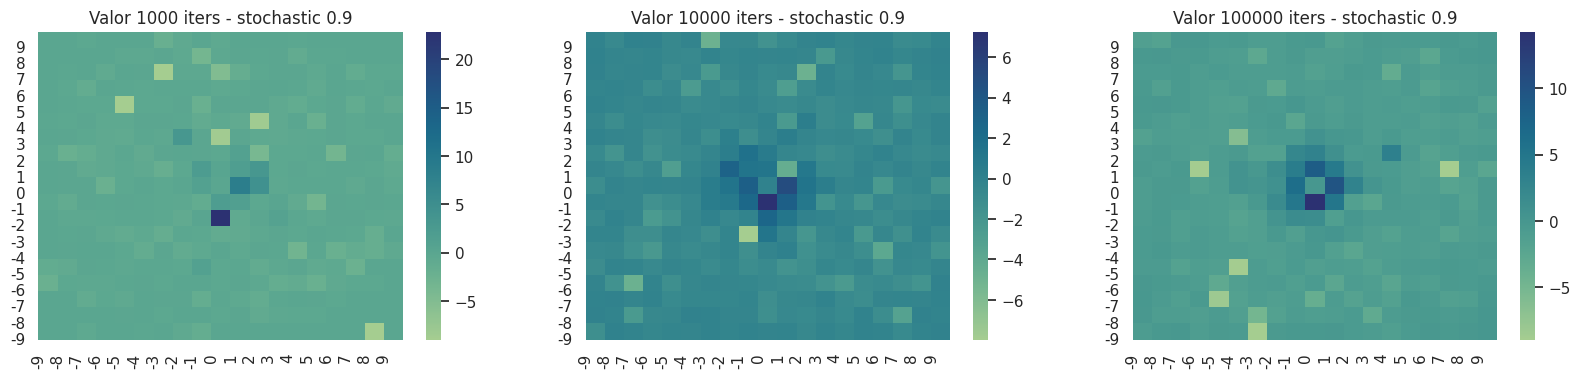

In [76]:
#A proxima célula le a função valor salva dos treinamentos anteriores e plota ela
# Assim, podemos avaliar como se comportam

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
for i, n in enumerate([1000, 10000, 100000]):
  with open(f'value_function_hyper_stochastic_all_{n}runs.pkl', 'rb') as fp:
    value_function = pickle.load(fp)

  #value_function = agent.value_function
  matrix_values = np.zeros((19, 19))
  for k in list(value_function.keys()):
    x = int(k.split(',')[0].split('(')[1])
    y = int(k.split(',')[1].split(')')[0])

    matrix_values[x+9][y+9] = value_function[k]

  matrix_values[9][9] = 0

  sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
  axs[i].invert_yaxis()
  axs[i].set_xticks(range(19))
  axs[i].set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
  axs[i].set_yticks(range(19))
  axs[i].set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
  axs[i].set_title(f'Valor {n} iters - stochastic 0.9')

Para testar as politicas:

In [14]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# with open(f'/content/value_function_{1000000}runs.pkl', 'rb') as fp:
#      value_function = pickle.load(fp)
# agent.value_function = value_function

In [15]:
# test_method(method = 'random')

In [16]:
# test_method(method = 'best')

In [17]:
# test_method(method = 'value')

Para testar o N0

In [18]:
# steps = []
# loop_ratios = []

# for N0 in [1, 10, 100, 1000, 10000]:

#   game = SnakeGame()
#   game.render()
#   agent = MonteCarloAgent(game)

#   agent.run_Monte_Carlo(num_samples = 10000, N0 = N0)

#   step, loop_ratio = test_method(method = 'value')
#   steps.append(step)
#   loop_ratios.append(loop_ratio)

#   print(steps, loop_ratios)

In [19]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = loop_ratios, ax = axs[0]).set_xscale("log")
# axs[0].set_title('Porcentagem de Loops Variando N0 (log scale)')
# axs[0].set_ylabel('% de Loops')

# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = steps, ax = axs[1]).set_xscale("log")
# axs[1].set_title('Número Médio de passos Variando N0 (log scale)')
# axs[1].set_ylabel('Tamanho médio do episódio')

# axs[0].set_xlabel('Parâmetro N0')
# axs[1].set_xlabel('Parâmetro N0')

## Análises Monte Carlo

### Avaliando o número de iterações de treino

A primeira análise a ser feita, leva em conta o um polica $ϵ$-greedy com N0 = 1000 e uma política de alpha escolhido dinâmicamente, diminuindo proporcionalmente a quantidade de vezes que já se passou pelo local, como se pede na descrição do trabalho.

Os resultados podem ser observados na figura abaixo, que mostra gráficos de calor indicando o valore de cada estado. O eixo x representa a distância do agente até a recompensa (comida ou fruta) no eixo e x, e o mesmo vale para o eixo y do gráfico:

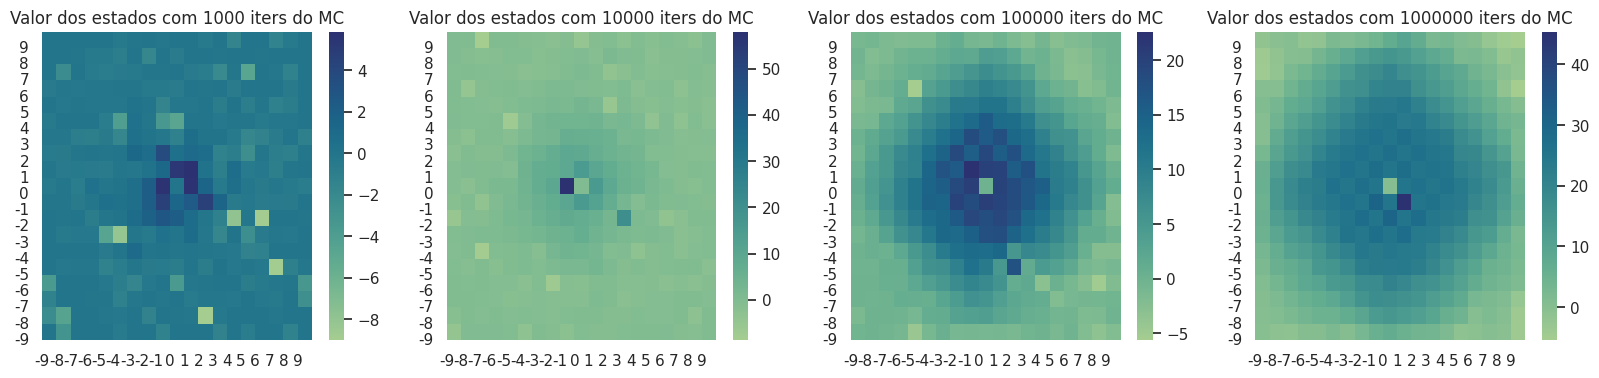

É possível observar que quanto mais o treinamento ocorre, melhor fica a aproximação para um valor ótimo, isto seria, onde os estados mais dintântes possuem valor mínimo e os estados mais centrais possuem valores maiores, considerante que o (0,0) é onde está a fruta, é onde deseja-se chegar.

Uma outra possível comparação a ser feita é saber quantos passos em média cada abordagem levaria para chegar na fruta. Os resultados montraram os seguintes valores (sendo a média de 1000 experimentos aleátórios) e comparados com a política aleatória e com uma regra ótima, criado por nós, que indica o melhor caminho possível sempre:

- Política aleatória: 239 passos em média
- Monte Carlo após 1 Milhão de iterações de treino: 70 passos em média
- Política ótima: 7 passos em média


Segundo nossos análises, o Monte Carlo atingiu o mesmo resultado na maioria dos experimentos, mas fica commédia maior por acabar caindo em loops e subindo a média, uma vez que consideramos a parada após 1000 passos sem chegar na fruta. As taxas de loops (ou episódios maiores que 1000) pode ser visto a seguir:

- Política aleatória: 3,7% de loops
- Monte Carlo após 1 Milhão de iterações de treino: 6,3% de loops
- Política ótima: sem loops


A fim de evitar Loops, fizemos um teste removendo a técnica $ϵ$-greedy na avaliação, e no lugar dela, adicionamos uma probabilidade de 1% de não seguir a política indicada pela função valor, mas sim escolher uma ação aleatória, evitando ficar preso em loops dessa forma.

O resultado foi uma redução para 0.1% de loops apenas e uma redução para 20.3 como tamanho médio do episódio. Mostrando assim que o método de Monte Carlo funcionou e perfoma de maneira bastante eficiente e conseguiu aprender a jogar no ambiente proposto.

### Avaliando o hiperparâmetro N0

A próxima análise a ser realizada se baseia no pararâmetro N0. Podemos ver a seguir um gráfico (em escala logarítimica no eixo x) da quantidade de loops ou episódios com mais de 1000 passos que ocorreram fixando o número de passos de treinamento do Monte Carlo como 10000 e avaliando o efeito da variação do N0 entre 1, 10, 100, 1000, 1000. Já o segundo o gráfico segue a mesma configuranção mas mostra o número médio de passos até se chegar a fruta nas diferentes configurações.


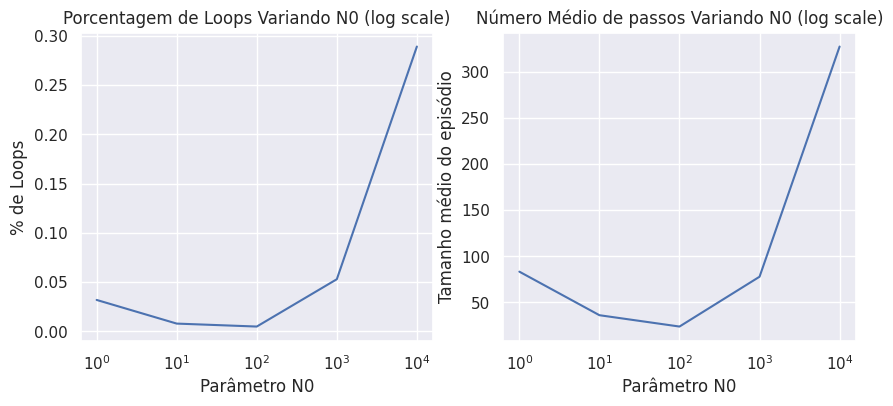

Para o nosso ambiente e nossas configurações coletadas, o que se mostrou mais eficaz foi o N0=100. Isso depende diretamente do problema sendo tratado, uma vez que o tamnho do npumero de estados pode influenciar muito nessa conta.

### Avaliando o ambiente estocástico

Para a avaliar o processo de aprendizado do agente em um ambiente estocático, foram realizados os seguintes exprimentos, fixando o N0=1000 do método ϵ-greedy e alterando o número de iterações de treino:

Para a avaliar a dificuldade no treino, de forma mais ampla, adiciona uma probabilidade de ação escolhida pelo a gente não se concretizar. De forma lúdica, pode ser visto como um "escorregão" ou um vento no agente durante a execução do episódio. Neste primeiro teste, qaulque lugar do tabuleiro pode ocorrer esses eventos aleatórios, abaixo estão mostrados os resultados para a probablidade de ocorrencia de 10%, 50% e 90% desses eventos aleatórios.

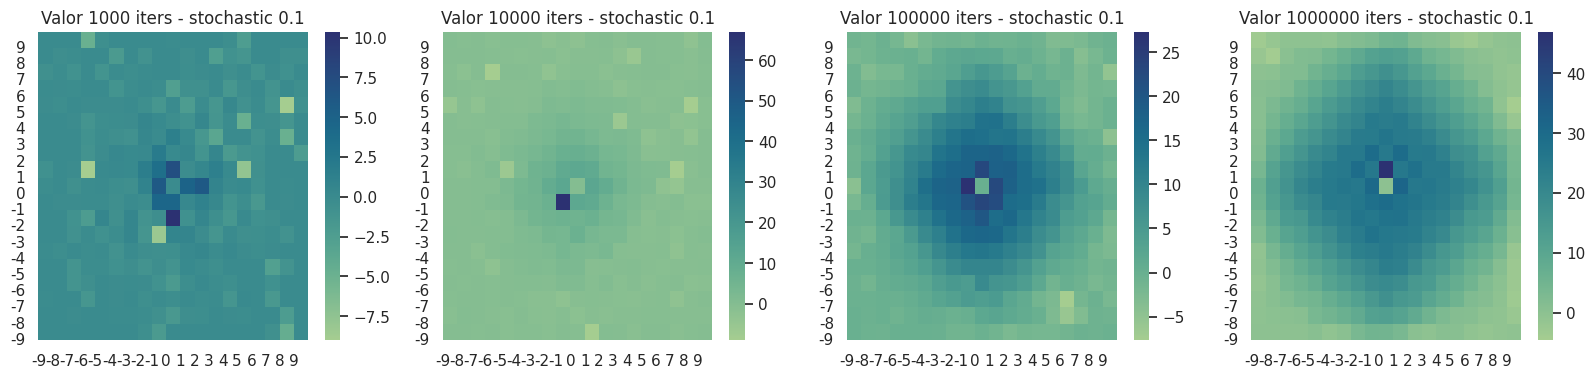

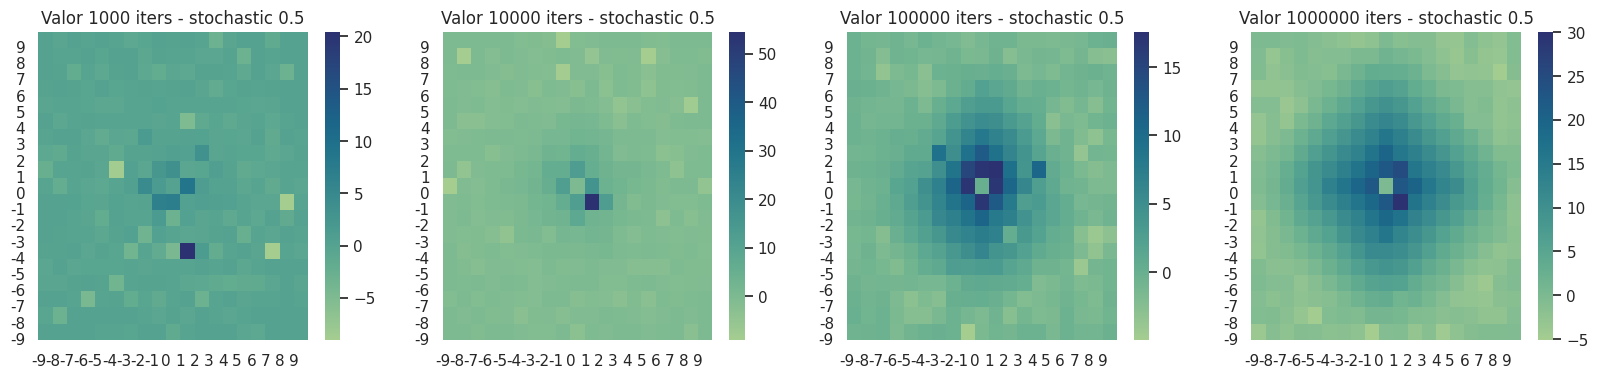

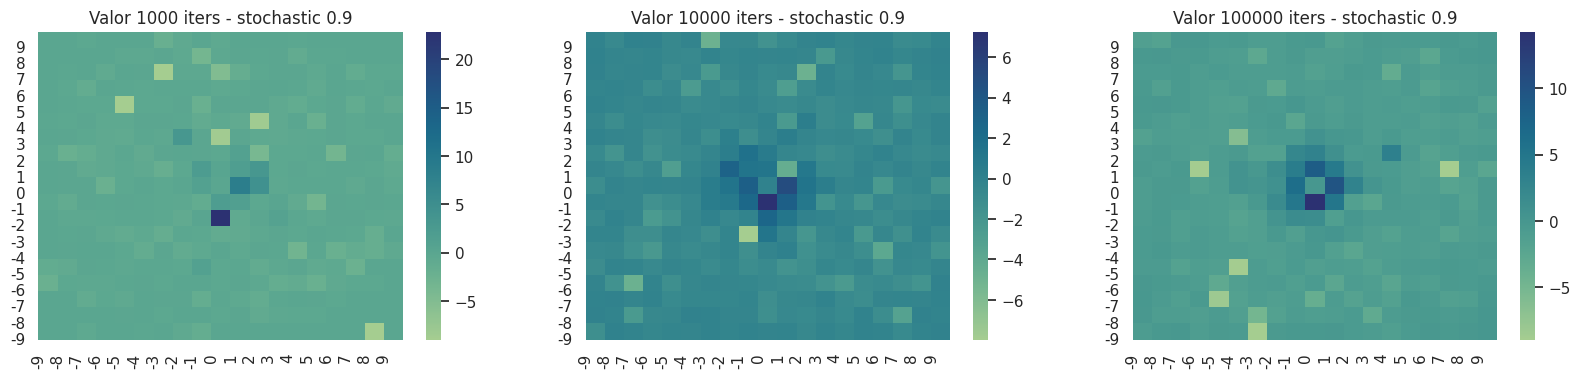

É possível notar, através da análise da uniformidade das cores dos estados representando o valor, nesses casos, a maior dificuldade de aprendizado do agente para ambientes mais estocáticos. Isso se deve por conta da dificuldade de atribuir o valor correto do estado no episódio, demandando mais iterações de treino para efetivamente conseguiur valorá-los.

A diferença nos maios numeros de iterações é evidente, uma vez que no ambiente menos estacástico a função valor ficou mais gradual e menos ruidosa, o agente aprendeu de forma muito mais lenta no caso de um ambiente mais estocástico.